# SHAP Interpretability Analysis (Binary Classification)

This notebook uses SHAP (SHapley Additive exPlanations) to interpret the LSTM model's predictions.

**SHAP provides:**
- Feature importance rankings
- Individual prediction explanations
- Global model behavior insights

**⚠️ OneDrive Workaround:** This notebook loads data/models from `/tmp/` to avoid timeout issues.

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import shap
from pathlib import Path

from src.utils import create_sequences, normalize_features
from src.models_lstm import create_model

# Create necessary directories
Path('../reports/figures').mkdir(parents=True, exist_ok=True)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

%matplotlib inline

print("✓ Setup complete - directories created")

✓ Setup complete - directories created


In [2]:
# Load dataset from /tmp (OneDrive workaround)
dataset_path = '/tmp/stock_prediction_data/dataset_binary.parquet'
df = pd.read_parquet(dataset_path)

print(f"✓ Loaded binary dataset from {dataset_path}")
print(f"Dataset shape: {df.shape}")
print(f"Binary classification: Up (+1) and Down (-1) only")

✓ Loaded binary dataset from /tmp/stock_prediction_data/dataset_binary.parquet
Dataset shape: (11136, 30)
Binary classification: Up (+1) and Down (-1) only


In [3]:
# Load trained model from /tmp (OneDrive workaround)
model_path = '/tmp/lstm_early_fusion_binary.pt'

# Force CPU for SHAP compatibility (CuDNN has issues with SHAP)
device = torch.device('cpu')
print("Using CPU for SHAP (required for CuDNN compatibility)")

checkpoint = torch.load(model_path, map_location=device, weights_only=False)
config = checkpoint['config']

model = create_model(
    model_type=config['model_type'],
    input_size=config['input_size'],
    hidden_size=config['hidden_size'],
    num_layers=config['num_layers'],
    dropout=config['dropout'],
    output_size=1
)

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

print(f"✓ Loaded model from {model_path}")
print(f"Model type: {config['model_type']}")
print(f"Model expects {config['input_size']} features")
print(f"Lookback: {config['lookback']}")

Using CPU for SHAP (required for CuDNN compatibility)
✓ Loaded model from /tmp/lstm_early_fusion_binary.pt
Model type: early_fusion
Model expects 25 features
Lookback: 30


In [4]:
# Prepare data - match model's expected features (25 features for full model)
df = df.set_index(pd.to_datetime(df['Date']))

# 80/20 train/test split
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print(f"Train: {len(train_df)} rows")
print(f"Test: {len(test_df)} rows")

# Select ALL 25 features that the model expects (including ALL sentiment features)
feature_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'return_1d', 'return_5d', 'volatility_5d', 'volatility_10d',
    'overnight_return', 'volume_ratio', 'price_to_ma5', 'price_to_ma20',
    'rsi', 'macd', 'macd_signal', 'macd_histogram',
    'pos', 'neg', 'neu', 'compound', 'sent_count',
    'pos_surprise', 'neg_surprise', 'compound_surprise'
]

# Use only features that exist in the dataset
available_features = [f for f in feature_cols if f in df.columns]

print(f"\nModel expects: {config['input_size']} features")
print(f"Available features: {len(available_features)}")

# Check if we have the right number of features
if len(available_features) != config['input_size']:
    print(f"\n⚠️  Feature mismatch!")
    print(f"   Expected: {config['input_size']}, Got: {len(available_features)}")
    print(f"   Missing features: {set(feature_cols) - set(available_features)}")
    raise ValueError(f"Feature count mismatch: model needs {config['input_size']}, data has {len(available_features)}")

X_train = train_df[available_features].values
X_test = test_df[available_features].values
y_test = test_df['target_return'].values

print(f"\n✓ Using {len(available_features)} features (matches model)")
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

# Normalize
X_train_norm, _, X_test_norm, _ = normalize_features(X_train, X_train, X_test)

# Create sequences
lookback = config['lookback']
X_test_seq, y_test_seq = create_sequences(X_test_norm, lookback, y_test)

print(f"\n✓ Test sequences: {X_test_seq.shape}")
print(f"✓ Features: {available_features}")

Train: 8908 rows
Test: 2228 rows

Model expects: 25 features
Available features: 25

✓ Using 25 features (matches model)
Train shape: (8908, 25)
Test shape: (2228, 25)

✓ Test sequences: (2198, 30, 25)
✓ Features: ['Open', 'High', 'Low', 'Close', 'Volume', 'return_1d', 'return_5d', 'volatility_5d', 'volatility_10d', 'overnight_return', 'volume_ratio', 'price_to_ma5', 'price_to_ma20', 'rsi', 'macd', 'macd_signal', 'macd_histogram', 'pos', 'neg', 'neu', 'compound', 'sent_count', 'pos_surprise', 'neg_surprise', 'compound_surprise']


In [5]:
# Put model in TRAINING mode for SHAP (required for gradient calculation)
model.train()
print("✓ Model set to training mode for SHAP")

# Use subset for SHAP (computationally expensive)
n_samples = min(50, len(X_test_seq))  # Reduced to 50 for speed
X_shap = X_test_seq[:n_samples]

print(f"Using {n_samples} samples for SHAP analysis")

✓ Model set to training mode for SHAP
Using 50 samples for SHAP analysis


In [6]:
# Create SHAP explainer
print("Creating SHAP explainer (this may take a minute)...")

background = X_test_seq[:10]  # Small background dataset
explainer = shap.DeepExplainer(model, torch.FloatTensor(background).to(device))

print("✓ Explainer created")

Creating SHAP explainer (this may take a minute)...
✓ Explainer created


In [7]:
# Calculate SHAP values
print("Calculating SHAP values (this may take 2-5 minutes)...")

shap_values = explainer.shap_values(torch.FloatTensor(X_shap).to(device))

print(f"✓ SHAP values calculated")
print(f"Shape: {shap_values.shape}")

Calculating SHAP values (this may take 2-5 minutes)...
✓ SHAP values calculated
Shape: (50, 30, 25, 1)


/Users/khoinguyenpham/Library/CloudStorage/OneDrive-CalPolyPomona/CS4200/Stock Prediction/.venv/lib/python3.14/site-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f"unrecognized nn.Module: {module_type}")


In [8]:
# Feature Importance
# Average absolute SHAP values across samples and time
# shap_values shape: (n_samples, lookback, n_features)
feature_importance = np.abs(shap_values).mean(axis=(0, 1))

# Ensure 1D array
if feature_importance.ndim > 1:
    feature_importance = feature_importance.flatten()

print(f"Feature importance shape: {feature_importance.shape}")
print(f"Number of features: {len(available_features)}")

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': available_features,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

Feature importance shape: (25,)
Number of features: 25

Top 10 Most Important Features:
         feature  importance
             rsi    0.000052
    price_to_ma5    0.000044
   price_to_ma20    0.000034
       return_5d    0.000030
          Volume    0.000028
overnight_return    0.000014
    volume_ratio    0.000013
       return_1d    0.000013
   volatility_5d    0.000009
  volatility_10d    0.000005


✓ Saved to /tmp/stock_prediction_figures/shap_feature_importance.png
⚠️  Could not save to project folder (OneDrive timeout)


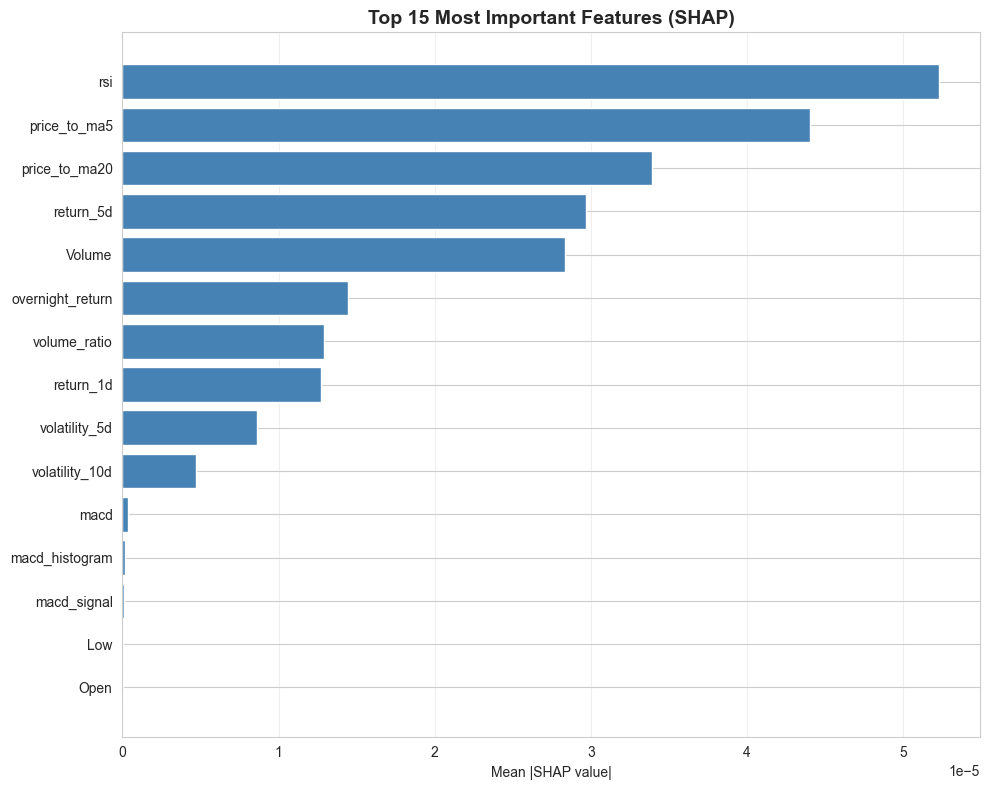

In [9]:
# Plot feature importance
plt.figure(figsize=(10, 8))
top_n = min(15, len(importance_df))
top_features = importance_df.head(top_n)

plt.barh(range(top_n), top_features['importance'].values, color='steelblue')
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Mean |SHAP value|')
plt.title(f'Top {top_n} Most Important Features (SHAP)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()

# Save to /tmp (OneDrive workaround)
plt.savefig('/tmp/stock_prediction_figures/shap_feature_importance.png', dpi=150, bbox_inches='tight')
print("✓ Saved to /tmp/stock_prediction_figures/shap_feature_importance.png")

# Try to also save to project folder
try:
    plt.savefig('../reports/figures/shap_feature_importance.png', dpi=150, bbox_inches='tight')
    print("✓ Also saved to reports/figures/shap_feature_importance.png")
except:
    print("⚠️  Could not save to project folder (OneDrive timeout)")

plt.show()

✓ Saved to /tmp/stock_prediction_figures/shap_summary_plot.png
⚠️  Could not save to project folder (OneDrive timeout)


<Figure size 1000x800 with 0 Axes>

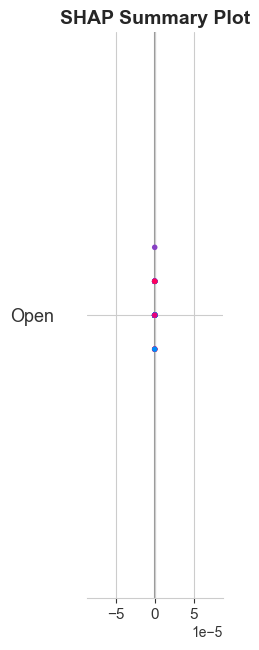

In [10]:
# SHAP Summary Plot
# Average over time dimension for visualization
shap_values_2d = shap_values.mean(axis=1)
X_shap_2d = X_shap.mean(axis=1)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_2d, X_shap_2d, feature_names=available_features, show=False)
plt.title('SHAP Summary Plot', fontsize=14, fontweight='bold')
plt.tight_layout()

# Save to /tmp (OneDrive workaround)
plt.savefig('/tmp/stock_prediction_figures/shap_summary_plot.png', dpi=150, bbox_inches='tight')
print("✓ Saved to /tmp/stock_prediction_figures/shap_summary_plot.png")

# Try to also save to project folder
try:
    plt.savefig('../reports/figures/shap_summary_plot.png', dpi=150, bbox_inches='tight')
    print("✓ Also saved to reports/figures/shap_summary_plot.png")
except:
    print("⚠️  Could not save to project folder (OneDrive timeout)")

plt.show()

In [11]:
# Summary
print("\n" + "="*60)
print("SHAP ANALYSIS COMPLETE")
print("="*60)

print("\nTop 5 Most Important Features:")
for i, row in importance_df.head(5).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")

print("\nPlots saved to reports/figures/")
print("  - shap_feature_importance.png")
print("  - shap_summary_plot.png")

print("\n✓ SHAP analysis complete!")


SHAP ANALYSIS COMPLETE

Top 5 Most Important Features:
  14. rsi: 0.0001
  12. price_to_ma5: 0.0000
  13. price_to_ma20: 0.0000
  7. return_5d: 0.0000
  5. Volume: 0.0000

Plots saved to reports/figures/
  - shap_feature_importance.png
  - shap_summary_plot.png

✓ SHAP analysis complete!
